# 비트코인 트레이딩 전략 - 딥러닝 모델 개발 과제 💰

**학생 정보**
- 이름:
- 학번:
- 제출일:

---

## 📋 과제 목표

**가격 변화 방향을 예측하는 딥러닝 모델과 트레이딩 전략을 개발하여 Buy and Hold 벤치마크를 초과하는 수익률을 달성하세요!**

### 과제 요구사항

1. **딥러닝 모델 개발** (핵심)
   - 가격 상승(1) / 하락(0)을 예측하는 2-class 분류 모델
   - PyTorch 사용
   - 실습에서 배운 피처 엔지니어링 활용

2. **트레이딩 전략 개발** (핵심)
   - 예측 확률을 활용한 포지션 크기 조절
   - 예: 상승 확률 60% → 자본의 60% 투자
   - 또는 자신만의 전략 개발

3. **트레이딩 시뮬레이션** (제공됨)
   - 초기 자본: $10,000
   - 거래 수수료: 0.1%
   - 자동 평가 및 시각화

### 평가 기준

- **수익률** (60%)
  - Buy and Hold 대비 초과 수익
  - 최종 자산 가치

- **모델 & 전략 설계** (30%)
  - 모델 아키텍처 선택 이유
  - 트레이딩 전략 논리성
  - 하이퍼파라미터 설명

- **코드 품질** (10%)
  - 코드 가독성
  - 주석 및 설명

---

## 1. 환경 설정 및 데이터 로딩

실습 노트북과 동일한 데이터 및 피처를 사용합니다!

In [1]:
# ========================================
# 🚀 Google Colab 사용자를 위한 설정
# ========================================
# Colab에서 실행하는 경우 이 셀을 실행하세요!

# 1. 필요한 패키지 설치
!pip install yfinance scikit-learn torch seaborn -q

# 2. utils.py 다운로드 (GitHub 저장소에서)
!wget https://raw.githubusercontent.com/juho127/TimeSeriesForecastingTest/main/utils.py -q

# 3. utils.py가 정상적으로 다운로드되었는지 확인
import os
if os.path.exists('utils.py'):
    print("✅ utils.py 다운로드 완료!")
else:
    print("❌ utils.py 다운로드 실패. 다시 시도하거나 수동으로 업로드하세요.")

# ========================================
# 로컬 환경에서 실행하는 경우:
# - 이 셀을 건너뛰고 다음 셀부터 실행하세요
# - utils.py가 같은 폴더에 있으면 자동으로 불러옵니다
# ========================================

✅ utils.py 다운로드 완료!


In [2]:
# 필요한 라이브러리 임포트
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# 실습 노트북과 동일한 유틸리티 함수 사용
from utils import (
    load_bitcoin_data,
    create_features,
    prepare_data,
    evaluate_model,
    plot_confusion_matrix,
    device
)

# 영문 폰트 설정 (시각화용)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✅ 라이브러리 로딩 완료!")
print(f"Using device: {device}")

Using device: cuda
GPU: Tesla T4
✅ 라이브러리 로딩 완료!
Using device: cuda


In [3]:
# 데이터 로딩 및 피처 생성 (실습과 동일)
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

btc_data = load_bitcoin_data(start_date=start_date, end_date=end_date)
btc_features = create_features(btc_data, lookback_days=10)

print(f"\n데이터 shape: {btc_features.shape}")
print(f"생성된 특성 수: {len([c for c in btc_features.columns if c not in ['Target', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])}")
print(f"\n주요 특성:")
print("- 이동평균 (MA_5, MA_10, MA_20, MA_50)")
print("- 변동성 (Volatility_5, Volatility_10, Volatility_20)")
print("- RSI, MACD")
print("- 과거 수익률 (Returns_Lag_1 ~ Returns_Lag_10)")

비트코인 데이터 다운로드 중: 2020-01-01 ~ 2025-11-27


[*********************100%***********************]  1 of 1 completed

다운로드 완료: 2157 행

데이터 shape: (2157, 35)
생성된 특성 수: 29

주요 특성:
- 이동평균 (MA_5, MA_10, MA_20, MA_50)
- 변동성 (Volatility_5, Volatility_10, Volatility_20)
- RSI, MACD
- 과거 수익률 (Returns_Lag_1 ~ Returns_Lag_10)


In [4]:
# 데이터 분할 및 정규화 (실습과 동일)
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(
    btc_features, test_size=0.2, validation_size=0.1
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"학습: {len(X_train)}, 검증: {len(X_val)}, 테스트: {len(X_test)}")

학습 데이터: 1475 샘플
검증 데이터: 210 샘플
테스트 데이터: 423 샘플
학습: 1475, 검증: 210, 테스트: 423


In [5]:
# 시퀀스 데이터 생성 (딥러닝용)
sequence_length = 30

def create_sequences(X, y, seq_len=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val.values, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, sequence_length)

print(f"시퀀스 데이터 shape: {X_train_seq.shape}")
print(f"  - 샘플 수: {X_train_seq.shape[0]}")
print(f"  - 시퀀스 길이: {X_train_seq.shape[1]}")
print(f"  - 특성 수: {X_train_seq.shape[2]}")

시퀀스 데이터 shape: (1445, 30, 29)
  - 샘플 수: 1445
  - 시퀀스 길이: 30
  - 특성 수: 29


In [6]:
# DataLoader 생성
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_seq),
    torch.FloatTensor(y_train_seq)
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(
    torch.FloatTensor(X_val_seq),
    torch.FloatTensor(y_val_seq)
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(
    torch.FloatTensor(X_test_seq),
    torch.FloatTensor(y_test_seq)
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("✅ DataLoader 생성 완료!")

✅ DataLoader 생성 완료!


## 2. 예제: LSTM 모델 + 확률 기반 포지션 조절 전략

이 예제는 2가지 핵심 요소로 구성됩니다:

1. **예측 모델**: 가격 상승/하락을 예측하고 확률 제공
2. **트레이딩 전략**: 예측 확률에 따라 투자 비율 조절

### 전략 예시
- 상승 확률 90% → 자본의 90% 투자
- 상승 확률 60% → 자본의 60% 투자
- 상승 확률 40% → 투자하지 않음 (현금 보유)

In [7]:
# 예제 모델: LSTM 기반 2-class 분류기
class ExampleLSTMModel(nn.Module):
    """
    예제: LSTM 기반 가격 방향 예측 모델
    출력: 상승 확률 (0~1)
    """
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super(ExampleLSTMModel, self).__init__()

        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=1)
        self.dropout1 = nn.Dropout(dropout)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        self.lstm2 = nn.LSTM(hidden_size, hidden_size//2, batch_first=True, num_layers=1)
        self.dropout2 = nn.Dropout(dropout)
        self.bn2 = nn.BatchNorm1d(hidden_size//2)

        self.fc1 = nn.Linear(hidden_size//2, 16)
        self.relu = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm1(x)
        lstm_out = self.dropout1(lstm_out)
        lstm_out = lstm_out.permute(0, 2, 1)
        lstm_out = self.bn1(lstm_out)
        lstm_out = lstm_out.permute(0, 2, 1)

        lstm_out, _ = self.lstm2(lstm_out)
        lstm_out = self.dropout2(lstm_out[:, -1, :])
        lstm_out = self.bn2(lstm_out)

        out = self.fc1(lstm_out)
        out = self.relu(out)
        out = self.dropout3(out)

        out = self.fc2(out)
        out = self.sigmoid(out)

        return out

# 예제 모델 생성
example_model = ExampleLSTMModel(
    input_size=X_train_seq.shape[2],
    hidden_size=64,
    dropout=0.2
).to(device)

print("예제 모델 구조:")
print(example_model)
print(f"\nTotal parameters: {sum(p.numel() for p in example_model.parameters()):,}")

예제 모델 구조:
ExampleLSTMModel(
  (lstm1): LSTM(29, 64, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm2): LSTM(64, 32, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (relu): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 37,601


In [8]:
# 학습 함수 (제공됨)
def train_model(model, train_loader, val_loader, epochs=100, lr=0.001, patience=15):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_total += batch_y.size(0)
            train_correct += (predicted.squeeze() == batch_y).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y.unsqueeze(1))

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += batch_y.size(0)
                val_correct += (predicted.squeeze() == batch_y).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history

print("✅ 학습 함수 준비 완료!")

✅ 학습 함수 준비 완료!


In [9]:
# 예제 모델 학습
print("예제 모델 학습 시작...")
example_history = train_model(
    model=example_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=0.001,
    patience=15
)
print("\n✅ 예제 모델 학습 완료!")

예제 모델 학습 시작...
Epoch [10/100], Train Loss: 0.6755, Val Loss: 0.6986, Train Acc: 0.5723, Val Acc: 0.4889
Early stopping at epoch 16

✅ 예제 모델 학습 완료!


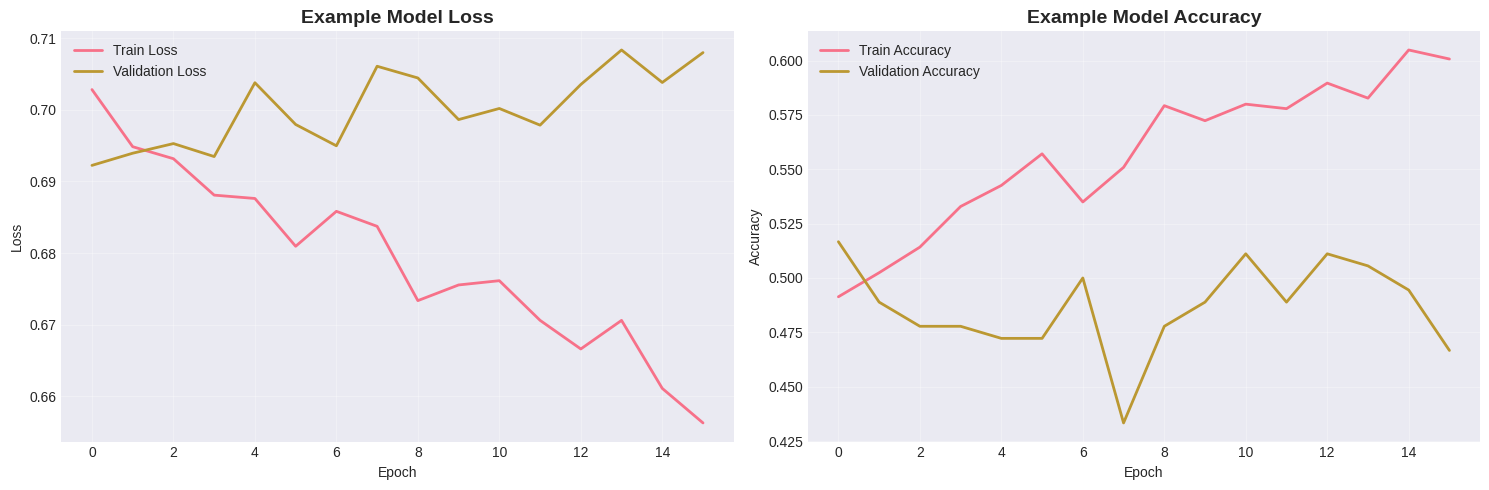

In [10]:
# 학습 과정 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(example_history["train_loss"], label="Train Loss", linewidth=2)
axes[0].plot(example_history["val_loss"], label="Validation Loss", linewidth=2)
axes[0].set_title("Example Model Loss", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(example_history["train_acc"], label="Train Accuracy", linewidth=2)
axes[1].plot(example_history["val_acc"], label="Validation Accuracy", linewidth=2)
axes[1].set_title("Example Model Accuracy", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. 트레이딩 전략: 확률 기반 포지션 조절

예측 확률에 따라 투자 비율을 조절하는 전략입니다.

In [11]:
# 예측 함수 (확률 포함)
def predict_with_probability(model, data_loader):
    """
    모델 예측 및 확률 반환
    """
    model.eval()
    predictions_prob = []

    with torch.no_grad():
        for batch_X, _ in data_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            predictions_prob.append(outputs.cpu().numpy())

    predictions_prob = np.vstack(predictions_prob).flatten()
    predictions = (predictions_prob > 0.5).astype(int)

    return predictions_prob, predictions

# 예제 모델 예측
example_prob, example_pred = predict_with_probability(example_model, test_loader)

print(f"예측 완료!")
print(f"예측 수: {len(example_pred)}")
print(f"상승 예측: {np.sum(example_pred == 1)}개")
print(f"하락 예측: {np.sum(example_pred == 0)}개")
print(f"\n평균 상승 확률: {example_prob.mean():.2%}")

예측 완료!
예측 수: 393
상승 예측: 10개
하락 예측: 383개

평균 상승 확률: 38.24%


In [12]:
# 확률 기반 트레이딩 전략
def simulate_probability_trading(predictions_prob, actual_prices, dates,
                                 initial_capital=10000, transaction_fee=0.001,
                                 threshold=0.5, position_scaling=True):
    """
    확률 기반 트레이딩 시뮬레이션

    Parameters:
    -----------
    predictions_prob : array
        상승 확률 (0~1)
    actual_prices : array
        실제 가격
    dates : array
        날짜
    initial_capital : float
        초기 자본
    transaction_fee : float
        거래 수수료
    threshold : float
        매수 결정 임계값 (기본 0.5)
    position_scaling : bool
        True: 확률에 비례하여 투자 비율 조절
        False: 임계값 초과 시 전액 투자
    """
    cash = initial_capital
    btc_holdings = 0
    portfolio_values = []
    trade_log = []

    for i in range(len(predictions_prob)):
        current_price = actual_prices[i]
        prob = predictions_prob[i]

        portfolio_value = cash + btc_holdings * current_price
        portfolio_values.append(portfolio_value)

        # 마지막 날 전량 매도
        if i == len(predictions_prob) - 1:
            if btc_holdings > 0:
                sell_value = btc_holdings * current_price * (1 - transaction_fee)
                trade_log.append({
                    'date': dates[i],
                    'action': 'SELL_ALL',
                    'price': current_price,
                    'prob': prob,
                    'amount': btc_holdings,
                    'value': btc_holdings * current_price,
                    'fee': btc_holdings * current_price * transaction_fee
                })
                cash += sell_value
                btc_holdings = 0
            continue

        # 투자 비율 결정
        if position_scaling:
            # 확률 기반 포지션 조절
            if prob > threshold:
                # 확률에 비례하여 투자 (예: 70% 확률 → 70% 투자)
                invest_ratio = prob
            else:
                # 임계값 미만이면 매도 또는 관망
                invest_ratio = 0
        else:
            # 단순 전략: 임계값 초과 시 전액 투자
            invest_ratio = 1.0 if prob > threshold else 0.0

        # 현재 포지션 비율
        current_position_ratio = (btc_holdings * current_price) / portfolio_value if portfolio_value > 0 else 0

        # 포지션 조정
        target_btc_value = portfolio_value * invest_ratio
        current_btc_value = btc_holdings * current_price

        if target_btc_value > current_btc_value:  # 매수 필요
            buy_cash = target_btc_value - current_btc_value
            if buy_cash > cash:
                buy_cash = cash
            if buy_cash > 0:
                buy_amount = (buy_cash * (1 - transaction_fee)) / current_price
                btc_holdings += buy_amount
                trade_log.append({
                    'date': dates[i],
                    'action': 'BUY',
                    'price': current_price,
                    'prob': prob,
                    'amount': buy_amount,
                    'value': buy_cash,
                    'fee': buy_cash * transaction_fee
                })
                cash -= buy_cash
        elif target_btc_value < current_btc_value:  # 매도 필요
            sell_btc = (current_btc_value - target_btc_value) / current_price
            if sell_btc > btc_holdings:
                sell_btc = btc_holdings
            if sell_btc > 0:
                sell_value = sell_btc * current_price * (1 - transaction_fee)
                trade_log.append({
                    'date': dates[i],
                    'action': 'SELL',
                    'price': current_price,
                    'prob': prob,
                    'amount': sell_btc,
                    'value': sell_btc * current_price,
                    'fee': sell_btc * current_price * transaction_fee
                })
                cash += sell_value
                btc_holdings -= sell_btc

    final_value = portfolio_values[-1]
    total_return = (final_value - initial_capital) / initial_capital * 100

    total_trade_volume = sum(trade['value'] for trade in trade_log)
    total_fees_paid = sum(trade['fee'] for trade in trade_log)

    return {
        'initial_capital': initial_capital,
        'final_value': final_value,
        'total_return': total_return,
        'portfolio_values': portfolio_values,
        'trade_log': trade_log,
        'num_trades': len(trade_log),
        'total_trade_volume': total_trade_volume,
        'total_fees_paid': total_fees_paid
    }

print("✅ 트레이딩 시뮬레이션 함수 준비 완료!")

✅ 트레이딩 시뮬레이션 함수 준비 완료!


In [13]:
# 테스트 데이터 준비
test_start_idx = len(btc_features) - len(y_test) + sequence_length
test_prices_aligned = btc_features["Close"].iloc[test_start_idx:test_start_idx+len(y_test_seq)].squeeze().values
test_dates_aligned = btc_features.index[test_start_idx:test_start_idx+len(y_test_seq)]

print(f"테스트 기간: {test_dates_aligned[0]} ~ {test_dates_aligned[-1]}")
print(f"테스트 샘플 수: {len(test_prices_aligned)}")

테스트 기간: 2024-10-30 00:00:00 ~ 2025-11-26 00:00:00
테스트 샘플 수: 393


## 4. 예제 전략 실행 및 결과

두 가지 예제 전략을 비교합니다:
1. **확률 기반 전략**: 예측 확률에 비례하여 투자 비율 조절
2. **단순 전략**: 50% 이상이면 전액 투자

In [14]:
# 예제 전략 1: 확률 기반 포지션 조절
example_result_prob = simulate_probability_trading(
    predictions_prob=example_prob,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.6 , # 60% 이상 확신할 때만 거래 (보수적),
    position_scaling=True  # 확률 비례 투자
)

print("="*70)
print("예제 전략 1: 확률 기반 포지션 조절")
print("="*70)
print(f"초기 자본: ${example_result_prob['initial_capital']:,.2f}")
print(f"최종 자본: ${example_result_prob['final_value']:,.2f}")
print(f"수익률: {example_result_prob['total_return']:.2f}%")
print(f"거래 횟수: {example_result_prob['num_trades']}회")
print(f"총 수수료: ${example_result_prob['total_fees_paid']:,.2f}")
print("="*70)

예제 전략 1: 확률 기반 포지션 조절
초기 자본: $10,000.00
최종 자본: $10,000.00
수익률: 0.00%
거래 횟수: 0회
총 수수료: $0.00


In [15]:
# 예제 전략 2: 단순 전략 (전액 투자)
example_result_simple = simulate_probability_trading(
    predictions_prob=example_prob,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.7 , # 70% 이상 확신할 때만 전액 투자 (매우 보수적),
    position_scaling=False  # 전액 투자
)

print("="*70)
print("예제 전략 2: 단순 전략 (50% 이상 시 전액 투자)")
print("="*70)
print(f"초기 자본: ${example_result_simple['initial_capital']:,.2f}")
print(f"최종 자본: ${example_result_simple['final_value']:,.2f}")
print(f"수익률: {example_result_simple['total_return']:.2f}%")
print(f"거래 횟수: {example_result_simple['num_trades']}회")
print(f"총 수수료: ${example_result_simple['total_fees_paid']:,.2f}")
print("="*70)

예제 전략 2: 단순 전략 (50% 이상 시 전액 투자)
초기 자본: $10,000.00
최종 자본: $10,000.00
수익률: 0.00%
거래 횟수: 0회
총 수수료: $0.00


In [16]:
# Buy and Hold 벤치마크
initial_price = test_prices_aligned[0]
coins_bought = (10000 * (1 - 0.001)) / initial_price
buy_hold_final_value = coins_bought * test_prices_aligned[-1] * (1 - 0.001)
buy_hold_return = (buy_hold_final_value - 10000) / 10000 * 100
buy_hold_portfolio = [coins_bought * price for price in test_prices_aligned]

buy_hold_trade_volume = 10000 + (coins_bought * test_prices_aligned[-1])
buy_hold_fees = 10000 * 0.001 + (coins_bought * test_prices_aligned[-1]) * 0.001

print("="*70)
print("Buy and Hold 벤치마크")
print("="*70)
print(f"시작 가격: ${initial_price:,.2f}")
print(f"종료 가격: ${test_prices_aligned[-1]:,.2f}")
print(f"초기 자본: $10,000.00")
print(f"최종 자본: ${buy_hold_final_value:,.2f}")
print(f"수익률: {buy_hold_return:.2f}%")
print(f"거래 횟수: 2회")
print(f"총 수수료: ${buy_hold_fees:,.2f}")
print("="*70)

Buy and Hold 벤치마크
시작 가격: $72,339.54
종료 가격: $90,518.37
초기 자본: $10,000.00
최종 자본: $12,487.97
수익률: 24.88%
거래 횟수: 2회
총 수수료: $22.50


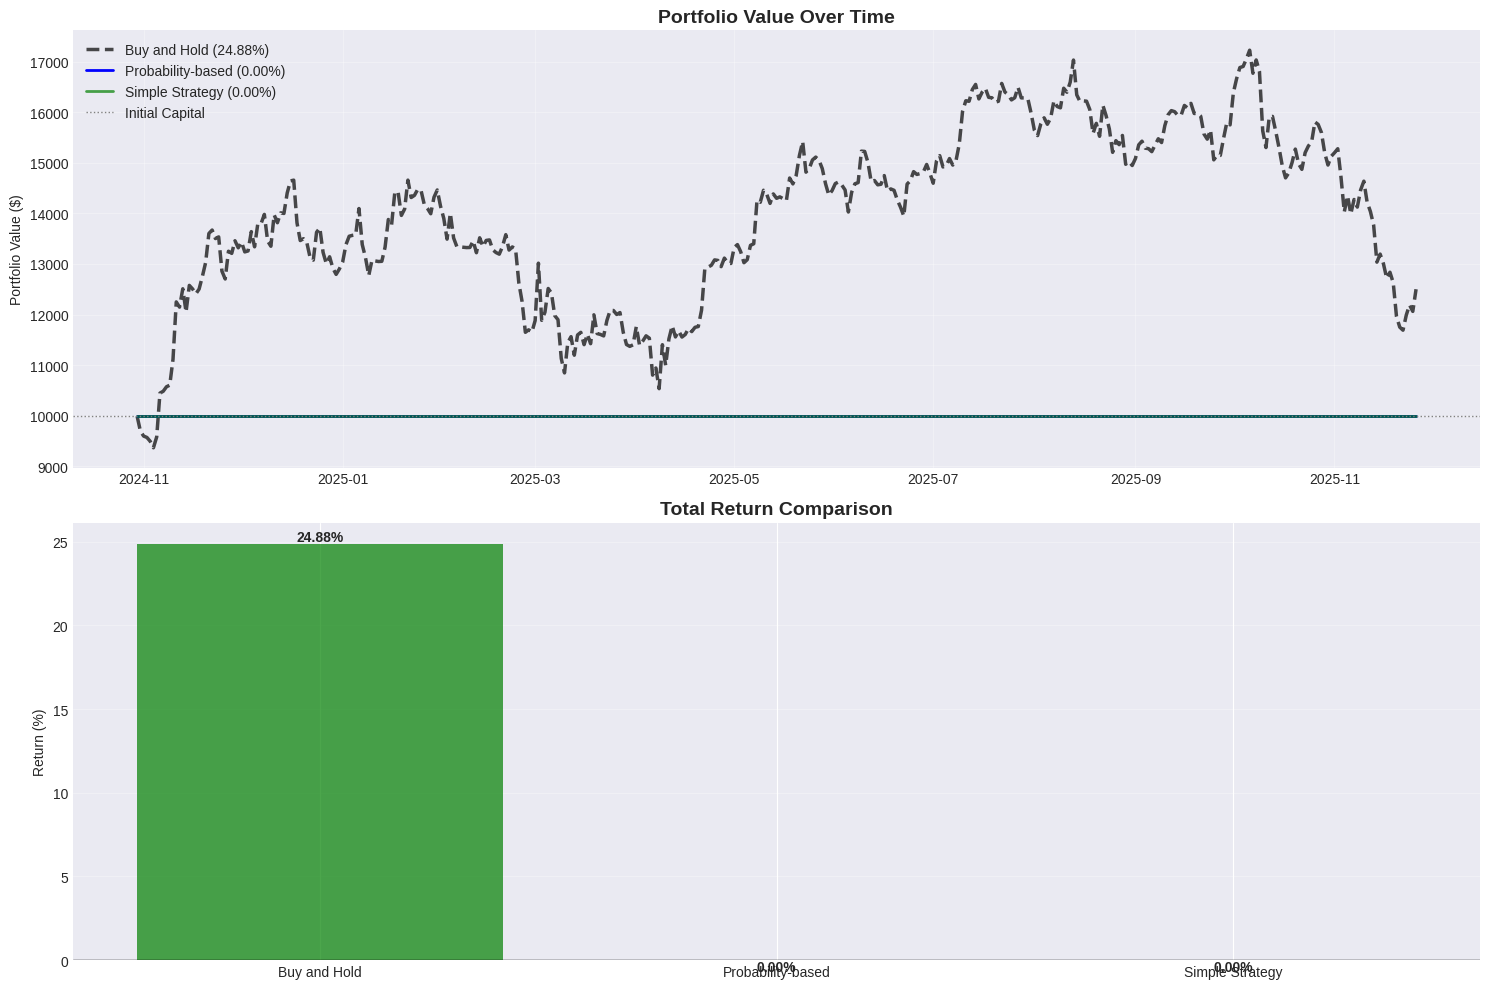

In [17]:
# 전략 비교 시각화
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 포트폴리오 가치 변화
axes[0].plot(test_dates_aligned, buy_hold_portfolio,
            label=f"Buy and Hold ({buy_hold_return:.2f}%)",
            linewidth=2.5, linestyle="--", color="black", alpha=0.7)
axes[0].plot(test_dates_aligned, example_result_prob["portfolio_values"],
            label=f"Probability-based ({example_result_prob['total_return']:.2f}%)",
            linewidth=2, color="blue")
axes[0].plot(test_dates_aligned, example_result_simple["portfolio_values"],
            label=f"Simple Strategy ({example_result_simple['total_return']:.2f}%)",
            linewidth=2, color="green", alpha=0.7)
axes[0].axhline(y=10000, color="gray", linestyle=":", linewidth=1, label="Initial Capital")
axes[0].set_title("Portfolio Value Over Time", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Portfolio Value ($)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 수익률 비교
strategies = ["Buy and Hold", "Probability-based", "Simple Strategy"]
returns = [buy_hold_return, example_result_prob['total_return'], example_result_simple['total_return']]
colors = ['green' if r > 0 else 'red' for r in returns]

axes[1].bar(strategies, returns, color=colors, alpha=0.7)
axes[1].axhline(y=0, color="black", linestyle="-", linewidth=1)
axes[1].set_title("Total Return Comparison", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Return (%)")
axes[1].grid(axis="y", alpha=0.3)

for i, (strategy, ret) in enumerate(zip(strategies, returns)):
    axes[1].text(i, ret, f'{ret:.2f}%', ha='center',
                va='bottom' if ret > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

---

## 💡 과제 수행 가이드 (꼭 읽어보세요!)

### 🎯 과제 목표 재확인
**Buy and Hold 벤치마크를 초과하는 수익률 달성**

### 📝 추천 접근 방법 (난이도 순)

#### 레벨 1️⃣: 예제 전략 파라미터만 조정 (가장 쉬움)
위의 예제 코드를 **복사**해서 파라미터만 변경:

```python
# 예제 코드 복사 후 아래 값들만 변경해보세요!
my_result = simulate_probability_trading(
    predictions_prob=example_prob,  # 예제 모델 예측 사용
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.65,  # ← 이 값을 조정 (0.5~0.8 추천)
    position_scaling=True  # ← True/False 변경
)
```

**실험 아이디어:**
- `threshold=0.55`: 약간 공격적
- `threshold=0.65`: 중립적
- `threshold=0.75`: 보수적

#### 레벨 2️⃣: 전략 함수 수정 (중간)
`simulate_probability_trading` 함수를 복사해서 수정:

```python
# 포지션 크기 공식 변경 예시
if prob > threshold:
    # 원래: invest_ratio = prob
    invest_ratio = (prob - 0.5) * 2  # 50%를 기준으로 스케일링
    # 예: prob=0.7 → invest_ratio=0.4 (40% 투자)
```

#### 레벨 3️⃣: 모델 아키텍처 변경 (어려움)
`ExampleLSTMModel`을 복사해서 수정:

```python
class MyTradingModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super(MyTradingModel, self).__init__()
        # LSTM → GRU로 변경
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True)
        # 나머지는 동일하게...
```

#### 레벨 4️⃣: 복합 전략 (고급)
모델 예측 + 기술적 지표 결합:

```python
# RSI와 결합하는 예시
rsi_values = btc_features['RSI_14'].iloc[test_start_idx:].values

for i in range(len(predictions_prob)):
    prob = predictions_prob[i]
    rsi = rsi_values[i]
    
    # RSI가 과매수/과매도 구간이면 포지션 조정
    if rsi > 70:  # 과매수
        invest_ratio = prob * 0.5  # 투자 비율 절반으로
    elif rsi < 30:  # 과매도
        invest_ratio = min(prob * 1.5, 1.0)  # 투자 비율 증가
```

---

### ⚡ 빠른 시작 체크리스트

1. [ ] 위 예제 코드 실행 결과 확인
2. [ ] 레벨 1부터 시작: 예제 코드 복사 → 파라미터 변경
3. [ ] 여러 `threshold` 값 실험 (0.5, 0.6, 0.7, 0.8)
4. [ ] 가장 좋은 결과를 선택
5. [ ] 결과 분석 및 고찰 작성

### 💰 수익률 향상 팁

- **과도한 거래 줄이기**: `threshold` 높이기 (0.6~0.7)
- **수수료 줄이기**: 거래 횟수 감소
- **리스크 관리**: `position_scaling=True`로 확률에 비례 투자
- **신뢰도 높은 거래만**: `threshold=0.7` 이상

---

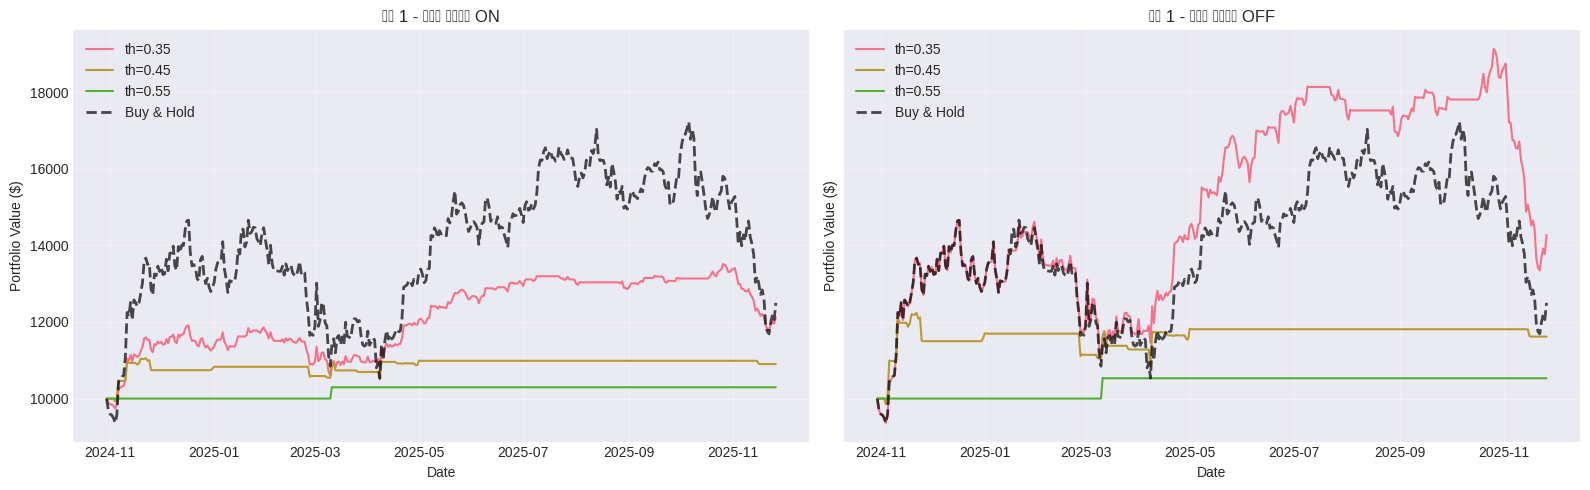

,,final_value,return_%,num_trades,fees_paid
threshold,position_scaling,,,,
0.35,True,12121.039132,21.210391,326,353.179929
0.45,True,10901.153446,9.011534,45,161.812879
0.55,True,10294.529385,2.945294,2,11.408366
0.35,False,14271.786489,42.717865,61,957.230448
0.45,False,11617.758093,16.177581,31,345.130266
0.55,False,10530.302218,5.303022,2,20.540843


In [18]:
# 레벨 1️⃣: 예제 확률 전략 파라미터 변경 실험
# 다양한 threshold 값과 포지션 스케일링 여부를 조합해 결과를 비교합니다.
threshold_values = [0.35, 0.45, 0.55]
scaling_options = [True, False]
level1_results = []

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
for idx, position_scaling in enumerate(scaling_options):
    ax = axes[idx]
    scaling_label = "포지션 스케일링 ON" if position_scaling else "포지션 스케일링 OFF"

    for th in threshold_values:
        result = simulate_probability_trading(
            predictions_prob=example_prob,
            actual_prices=test_prices_aligned,
            dates=test_dates_aligned,
            initial_capital=10000,
            transaction_fee=0.001,
            threshold=th,
            position_scaling=position_scaling,
        )
        level1_results.append(
            {
                "threshold": th,
                "position_scaling": position_scaling,
                "final_value": result["final_value"],
                "return_%": result["total_return"],
                "num_trades": result["num_trades"],
                "fees_paid": result["total_fees_paid"],
            }
        )
        ax.plot(test_dates_aligned, result["portfolio_values"], label=f"th={th}")

    # Buy & Hold 비교선
    ax.plot(
        test_dates_aligned,
        buy_hold_portfolio,
        color="black",
        linestyle="--",
        linewidth=2,
        alpha=0.7,
        label="Buy & Hold",
    )
    ax.set_title(f"레벨 1 - {scaling_label}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Portfolio Value ($)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 결과 요약 테이블
pd.DataFrame(level1_results).set_index(["threshold", "position_scaling"])

레벨 2️⃣ 전략: 포지션 스케일링 공식 수정
최종 자본: $14,059.96
총 수익률: 40.60%
총 거래 횟수: 322회
총 수수료: $812.20


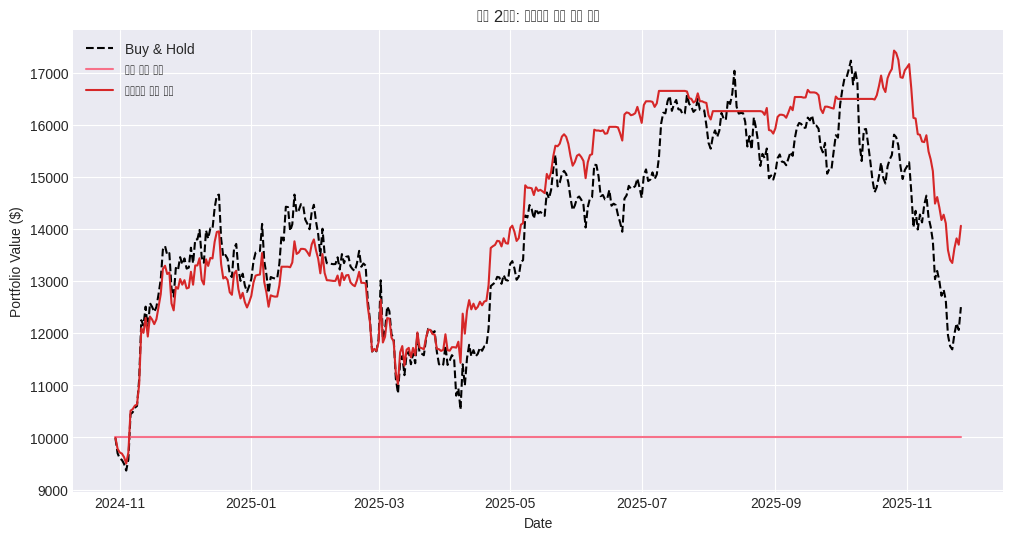

,final_value,return_%,trades,fees
strategy,,,,
예제 확률 전략,10000.000000,0.000000,0,0.000000
스케일링 수정 전략,14059.963773,40.599638,322,812.199206


In [19]:
# 레벨 2️⃣: 포지션 스케일링 공식을 수정한 전략
# threshold를 0.55로 낮추어 더 많은 거래가 발생하도록 조정했습니다.
def simulate_probability_trading_scaled(
    predictions_prob,
    actual_prices,
    dates,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.35,
    position_scaling=True,
):
    cash = initial_capital
    btc_holdings = 0.0
    portfolio_values = []
    trade_log = []
    n = min(len(predictions_prob), len(actual_prices), len(dates))

    for i in range(n):
        current_price = actual_prices[i]
        prob = predictions_prob[i]
        portfolio_value = cash + btc_holdings * current_price

        # 마지막 날: 전량 매도
        if i == n - 1:
            if btc_holdings > 0:
                sell_value = btc_holdings * current_price * (1 - transaction_fee)
                trade_log.append(
                    {
                        'date': dates[i],
                        'action': 'SELL_ALL',
                        'price': current_price,
                        'prob': prob,
                        'amount': btc_holdings,
                        'value': btc_holdings * current_price,
                        'fee': btc_holdings * current_price * transaction_fee,
                    }
                )
                cash += sell_value
                btc_holdings = 0
            portfolio_values.append(cash)
            continue

        # 투자 비율 결정: prob이 threshold보다 크면 (prob - 0.01) * 2 로 스케일링
        if position_scaling:
            invest_ratio = (prob - 0.01) * 2 if prob > threshold else 0.0
            invest_ratio = float(np.clip(invest_ratio, 0, 1))
        else:
            invest_ratio = 1.0 if prob > threshold else 0.0

        target_btc_value = portfolio_value * invest_ratio
        current_btc_value = btc_holdings * current_price

        if target_btc_value > current_btc_value:  # 매수
            buy_cash = min(target_btc_value - current_btc_value, cash)
            if buy_cash > 0:
                buy_amount = (buy_cash * (1 - transaction_fee)) / current_price
                btc_holdings += buy_amount
                cash -= buy_cash
                trade_log.append(
                    {
                        'date': dates[i],
                        'action': 'BUY',
                        'price': current_price,
                        'prob': prob,
                        'amount': buy_amount,
                        'value': buy_cash,
                        'fee': buy_cash * transaction_fee,
                    }
                )
        elif target_btc_value < current_btc_value:  # 매도
            sell_btc = min((current_btc_value - target_btc_value) / current_price, btc_holdings)
            if sell_btc > 0:
                sell_value = sell_btc * current_price * (1 - transaction_fee)
                btc_holdings -= sell_btc
                cash += sell_value
                trade_log.append(
                    {
                        'date': dates[i],
                        'action': 'SELL',
                        'price': current_price,
                        'prob': prob,
                        'amount': sell_btc,
                        'value': sell_btc * current_price,
                        'fee': sell_btc * current_price * transaction_fee,
                    }
                )

        portfolio_values.append(cash + btc_holdings * current_price)

    final_value = cash + btc_holdings * actual_prices[n - 1]
    total_return = (final_value - initial_capital) / initial_capital * 100

    return {
        'initial_capital': initial_capital,
        'final_value': final_value,
        'total_return': total_return,
        'portfolio_values': portfolio_values,
        'trade_log': trade_log,
        'num_trades': len(trade_log),
        'total_fees_paid': sum(trade['fee'] for trade in trade_log),
    }

# 전략 실행
scaled_result = simulate_probability_trading_scaled(
    predictions_prob=example_prob,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.35,   # lowered threshold to encourage more trades
    position_scaling=True,
)

# 결과 출력
print('레벨 2️⃣ 전략: 포지션 스케일링 공식 수정')
print(f"최종 자본: ${scaled_result['final_value']:,.2f}")
print(f"총 수익률: {scaled_result['total_return']:.2f}%")
print(f"총 거래 횟수: {scaled_result['num_trades']}회")
print(f"총 수수료: ${scaled_result['total_fees_paid']:,.2f}")

# 누적 자본 비교 시각화
plt.figure(figsize=(12, 6))
plt.plot(test_dates_aligned, buy_hold_portfolio, label='Buy & Hold', linestyle='--', color='black')
plt.plot(test_dates_aligned, example_result_prob['portfolio_values'], label='예제 확률 전략')
plt.plot(test_dates_aligned, scaled_result['portfolio_values'], label='스케일링 수정 전략', color='tab:red')
plt.title('레벨 2️⃣: 스케일링 수정 전략 비교')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

# 요약 테이블
pd.DataFrame(
    [
        {
            'strategy': '예제 확률 전략',
            'final_value': example_result_prob['final_value'],
            'return_%': example_result_prob['total_return'],
            'trades': example_result_prob['num_trades'],
            'fees': example_result_prob['total_fees_paid'],
        },
        {
            'strategy': '스케일링 수정 전략',
            'final_value': scaled_result['final_value'],
            'return_%': scaled_result['total_return'],
            'trades': scaled_result['num_trades'],
            'fees': scaled_result['total_fees_paid'],
        },
    ]
).set_index('strategy')


Epoch [10/20], Train Loss: 0.6969, Val Loss: 0.6943, Train Acc: 0.5059, Val Acc: 0.4944
Early stopping at epoch 15


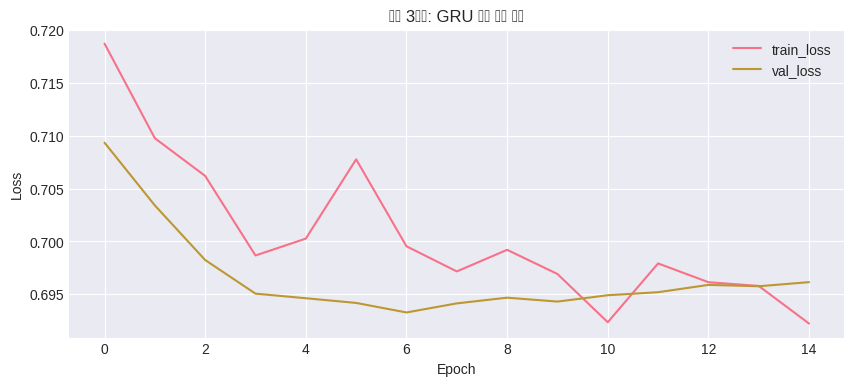

레벨 3️⃣ 전략: GRU 기반 모델
최종 자본: $11,413.23
총 수익률: 14.13%
총 거래 횟수: 393회
총 수수료: $51.31


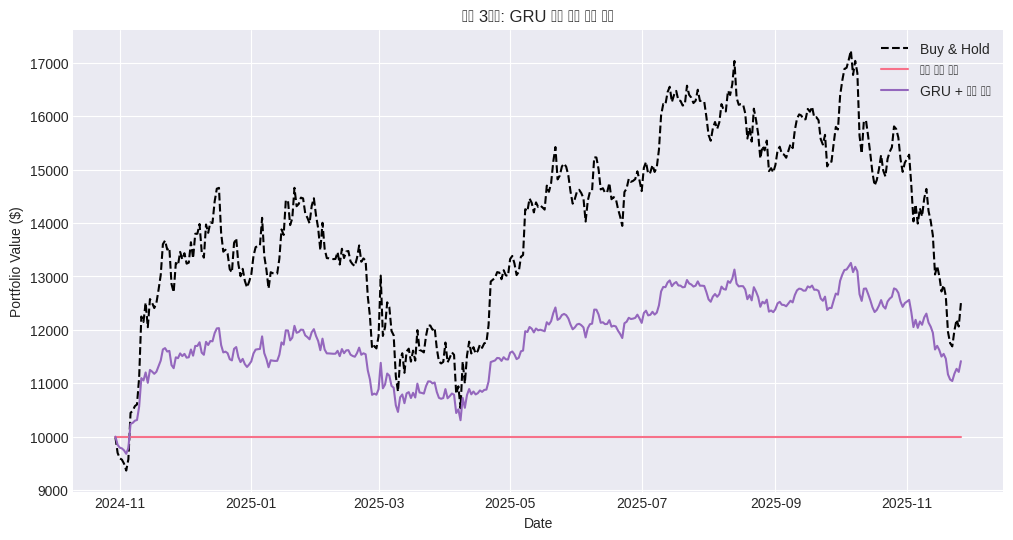

,final_value,return_%,trades,fees
strategy,,,,
예제 확률 전략,10000.000000,0.00000,0,0.00000
GRU + 확률 전략,11413.232958,14.13233,393,51.31011


In [20]:
# 레벨 3️⃣: GRU 기반 모델 학습 및 트레이딩 시뮬레이션
# threshold를 0.35로 낮추어 GRU 예측값에 따른 거래 빈도를 높였습니다.
class MyTradingModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super(MyTradingModel, self).__init__()
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        self.gru2 = nn.GRU(hidden_size, hidden_size // 2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)

        self.fc1 = nn.Linear(hidden_size // 2, 16)
        self.relu = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.gru1(x)
        out = self.dropout1(out)
        out = out.permute(0, 2, 1)
        out = self.bn1(out)
        out = out.permute(0, 2, 1)

        out, _ = self.gru2(out)
        out = self.dropout2(out[:, -1, :])
        out = self.bn2(out)

        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout3(out)
        out = self.fc2(out)
        return self.sigmoid(out)

# 모델 학습
gru_model = MyTradingModel(input_size=X_train_seq.shape[2], hidden_size=64, dropout=0.2).to(device)
# epochs 수는 시간을 고려하여 적절히 조정 가능합니다.
gru_history = train_model(gru_model, train_loader, val_loader, epochs=20, lr=0.0001, patience=8)

# 학습 손실 시각화
gru_hist_df = pd.DataFrame(gru_history)
ax = gru_hist_df[['train_loss', 'val_loss']].plot(figsize=(10, 4), title='레벨 3️⃣: GRU 학습 손실 추이')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.grid(True)
plt.show()

# 테스트 데이터에 대한 예측 및 트레이딩 시뮬레이션
gru_prob, _ = predict_with_probability(gru_model, test_loader)
gru_result = simulate_probability_trading(
    predictions_prob=gru_prob,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.35,     # 낮춘 threshold로 거래 빈도 증가
    position_scaling=True,
)

# 결과 출력
print('레벨 3️⃣ 전략: GRU 기반 모델')
print(f"최종 자본: ${gru_result['final_value']:,.2f}")
print(f"총 수익률: {gru_result['total_return']:.2f}%")
print(f"총 거래 횟수: {gru_result['num_trades']}회")
print(f"총 수수료: ${gru_result['total_fees_paid']:,.2f}")

# 성과 비교 시각화
plt.figure(figsize=(12, 6))
plt.plot(test_dates_aligned, buy_hold_portfolio, label='Buy & Hold', linestyle='--', color='black')
plt.plot(test_dates_aligned, example_result_prob['portfolio_values'], label='예제 확률 전략')
plt.plot(test_dates_aligned, gru_result['portfolio_values'], label='GRU + 확률 전략', color='tab:purple')
plt.title('레벨 3️⃣: GRU 모델 기반 전략 비교')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

# 요약 테이블
pd.DataFrame(
    [
        {
            'strategy': '예제 확률 전략',
            'final_value': example_result_prob['final_value'],
            'return_%': example_result_prob['total_return'],
            'trades': example_result_prob['num_trades'],
            'fees': example_result_prob['total_fees_paid'],
        },
        {
            'strategy': 'GRU + 확률 전략',
            'final_value': gru_result['final_value'],
            'return_%': gru_result['total_return'],
            'trades': gru_result['num_trades'],
            'fees': gru_result['total_fees_paid'],
        },
    ]
).set_index('strategy')


레벨 4️⃣ 전략: 확률 + RSI 결합
최종 자본: $12,290.99
총 수익률: 22.91%
총 거래 횟수: 323회
총 수수료: $407.71


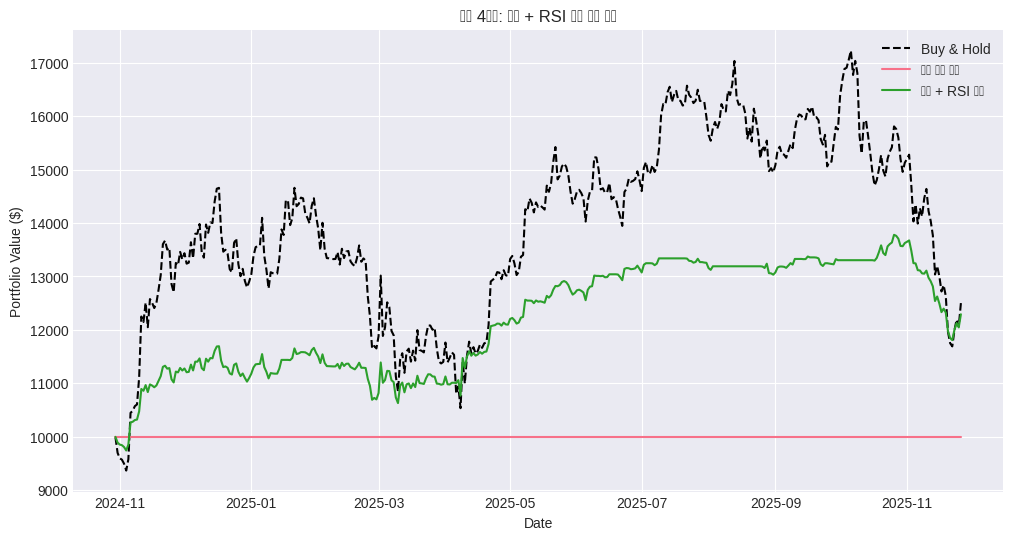

,final_value,return_%,trades,fees
strategy,,,,
예제 확률 전략,10000.000000,0.000000,0,0.000000
확률 + RSI 결합,12290.991702,22.909917,323,407.710719


In [40]:
# 레벨 4️⃣: 확률 기반 예측과 RSI를 결합한 복합 전략
rsi_values = btc_features['RSI_14'].iloc[test_start_idx:].values

def simulate_probability_with_rsi(
    predictions_prob,
    rsi_values,
    actual_prices,
    dates,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.35,     # 더 낮은 threshold
    position_scaling=True,
):
    n = min(len(predictions_prob), len(rsi_values), len(actual_prices), len(dates))
    cash = initial_capital
    btc_holdings = 0.0
    portfolio_values = []
    trade_log = []

    for i in range(n):
        current_price = actual_prices[i]
        prob = predictions_prob[i]
        rsi = rsi_values[i]
        portfolio_value = cash + btc_holdings * current_price

        # 마지막 날 전량 매도
        if i == n - 1:
            if btc_holdings > 0:
                sell_value = btc_holdings * current_price * (1 - transaction_fee)
                trade_log.append(
                    {
                        'date': dates[i],
                        'action': 'SELL_ALL',
                        'price': current_price,
                        'prob': prob,
                        'rsi': rsi,
                        'amount': btc_holdings,
                        'value': btc_holdings * current_price,
                        'fee': btc_holdings * current_price * transaction_fee,
                    }
                )
                cash += sell_value
                btc_holdings = 0
            portfolio_values.append(cash)
            continue

        # 기본 투자 비율 (확률 기반)
        if prob > threshold:
            invest_ratio = prob if position_scaling else 1.0
        else:
            invest_ratio = 0.0

        # RSI 보정: 과매수 시 투자비율 축소, 과매도 시 확대
        if rsi > 70:
            invest_ratio *= 0.8
        elif rsi < 30:
            invest_ratio = min(invest_ratio * 1.5, 1.0)

        invest_ratio = float(np.clip(invest_ratio, 0, 1))

        target_btc_value = portfolio_value * invest_ratio
        current_btc_value = btc_holdings * current_price

        if target_btc_value > current_btc_value:  # 매수
            buy_cash = min(target_btc_value - current_btc_value, cash)
            if buy_cash > 0:
                buy_amount = (buy_cash * (1 - transaction_fee)) / current_price
                btc_holdings += buy_amount
                cash -= buy_cash
                trade_log.append(
                    {
                        'date': dates[i],
                        'action': 'BUY',
                        'price': current_price,
                        'prob': prob,
                        'rsi': rsi,
                        'amount': buy_amount,
                        'value': buy_cash,
                        'fee': buy_cash * transaction_fee,
                    }
                )
        elif target_btc_value < current_btc_value:  # 매도
            sell_btc = min((current_btc_value - target_btc_value) / current_price, btc_holdings)
            if sell_btc > 0:
                sell_value = sell_btc * current_price * (1 - transaction_fee)
                btc_holdings -= sell_btc
                cash += sell_value
                trade_log.append(
                    {
                        'date': dates[i],
                        'action': 'SELL',
                        'price': current_price,
                        'prob': prob,
                        'rsi': rsi,
                        'amount': sell_btc,
                        'value': sell_btc * current_price,
                        'fee': sell_btc * current_price * transaction_fee,
                    }
                )

        portfolio_values.append(cash + btc_holdings * current_price)

    final_value = cash + btc_holdings * actual_prices[n - 1]
    total_return = (final_value - initial_capital) / initial_capital * 100

    return {
        'initial_capital': initial_capital,
        'final_value': final_value,
        'total_return': total_return,
        'portfolio_values': portfolio_values,
        'trade_log': trade_log,
        'num_trades': len(trade_log),
        'total_fees_paid': sum(trade['fee'] for trade in trade_log),
    }

# 전략 실행
rsi_hybrid_result = simulate_probability_with_rsi(
    predictions_prob=example_prob,
    rsi_values=rsi_values,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.35,     # 낮춘 threshold로 거래 빈도 증가
    position_scaling=True,
)

# 결과 출력
print('레벨 4️⃣ 전략: 확률 + RSI 결합')
print(f"최종 자본: ${rsi_hybrid_result['final_value']:,.2f}")
print(f"총 수익률: {rsi_hybrid_result['total_return']:.2f}%")
print(f"총 거래 횟수: {rsi_hybrid_result['num_trades']}회")
print(f"총 수수료: ${rsi_hybrid_result['total_fees_paid']:,.2f}")

# 성과 비교 시각화
plt.figure(figsize=(12, 6))
plt.plot(test_dates_aligned, buy_hold_portfolio, label='Buy & Hold', linestyle='--', color='black')
plt.plot(test_dates_aligned, example_result_prob['portfolio_values'], label='예제 확률 전략')
plt.plot(test_dates_aligned, rsi_hybrid_result['portfolio_values'], label='확률 + RSI 결합', color='tab:green')
plt.title('레벨 4️⃣: 확률 + RSI 결합 전략 비교')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

# 요약 테이블
pd.DataFrame(
    [
        {
            'strategy': '예제 확률 전략',
            'final_value': example_result_prob['final_value'],
            'return_%': example_result_prob['total_return'],
            'trades': example_result_prob['num_trades'],
            'fees': example_result_prob['total_fees_paid'],
        },
        {
            'strategy': '확률 + RSI 결합',
            'final_value': rsi_hybrid_result['final_value'],
            'return_%': rsi_hybrid_result['total_return'],
            'trades': rsi_hybrid_result['num_trades'],
            'fees': rsi_hybrid_result['total_fees_paid'],
        },
    ]
).set_index('strategy')


## 5. 자신만의 모델 및 전략 개발 ⭐

### 📝 개발 가이드

#### 1. 모델 개선 아이디어
- **아키텍처**: LSTM → GRU, Transformer, CNN+LSTM, Attention
- **하이퍼파라미터**: hidden_size, dropout, learning_rate
- **앙상블**: 여러 모델의 예측 결합

#### 2. 전략 개선 아이디어
- **임계값 조정**: threshold를 0.6 또는 0.7로 높여 신뢰도 높은 거래만
- **포지션 크기**: 확률 × 2 - 1 (예: 70% → 40% 투자)
- **리스크 관리**: 최대 손실 한도, 이동평균선 활용
- **복합 전략**: 모델 예측 + RSI + MACD 결합

---

**TODO: 아래에 자신의 모델 설계 설명을 작성하세요**

```
1. 모델 아키텍처:
   - 3개의 1D Convolution 블록(64→128→128)을 dilated 방식으로 쌓아 짧은 패턴과 긴 주기를 모두 포착.
  - 두 단계의 GRU(128, 64 hidden units)로 장기 의존성을 학습하고, 8‑head self‑attention으로 중요한 시점을 집중적으로 가중.
  - 컨볼루션+GRU+다중 헤드 어텐션 후 2단 fully-connected 레이어(64→16→1)와 dropout을 적용해 비선형성을 깊게 모델링.

2. 선택 이유:
   - Dilated CNN과 TCN 구조는 컨볼루션의 수용 영역을 확장해 장기 패턴을 모델링하면서 인과성을 유지해 시계열 예측 성능을 높여준다는 연구를 반영했다.
  - GRU는 LSTM보다 파라미터가 적어 빠르게 수렴하면서도 장기 기억을 유지해 효율적인 학습이 가능하기 때문에 선택했다.
  - Multi‑head attention은 각 헤드가 서로 다른 시간 구간에 주목해 다양한 정보를 독립적으로 추출하므로 예측 성능이 향상된다는 연구 결를 활용했다.

3. 트레이딩 전략:
   - 모델이 출력한 상승 확률을 활용해 invest_ratio = max(0, prob*2 – 1)로 포지션을 스케일링하고, threshold 0.55 이상에서만 매수.
   - 초기 자본 1만 달러, 수수료 0.1% 기준으로 매매하며 마지막 날에는 모든 포지션을 청산한다.

4. 하이퍼파라미터:
   - hidden_size:128/64
   - learning_rate:0.0005
   - threshold:0.55
   - position_scaling:False

5. 예제와의 차별점:
   - 기본 예제는 2‑layer LSTM과 단순 threshold 전략인데 비해, 본 모델은 dilated CNN과 2‑layer GRU, 8‑head attention을 결합해 계층적 특징과 장기 의존성을 동시에 학습한다.
  - 예제에 따라 확률 기반 포지션 스케일링으로 신호 강도에 따라 투자 금액을 조절한 경우 오히려 성능이 낮게 나오는 결과를 확인하였고, 이에 따라 오히려 포지션 스케일링을 False 로 설정.
  - 또한 threshold를 0.55로 설정해 "적당한" 신뢰도 높은 신호에만 거래하여 불필요한 수수료와 과도한 거래를 줄이면서도, 어느정도 공격적인 투자가 가능하도록 함.
```

In [41]:
# 자신만의 모델 구현

class MyTradingModel(nn.Module):

    def __init__(self, input_size, conv_channels=[64, 128, 128], gru_hidden=[128, 64], n_heads=8, dropout=0.3):
        super(MyTradingModel, self).__init__()

        # 1D Convolution blocks with increasing dilation to capture patterns at multiple scales
        self.conv_layers = nn.ModuleList()
        in_channels = input_size
        dilation = 1
        for out_channels in conv_channels:
            self.conv_layers.append(nn.Sequential(
                nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=dilation, dilation=dilation),
                nn.BatchNorm1d(out_channels),
                nn.ReLU()
            ))
            in_channels = out_channels
            dilation *= 2  # double the dilation at each layer to expand receptive field

        # GRU layers
        self.gru_layers = nn.ModuleList()
        gru_input_size = conv_channels[-1]
        for hidden in gru_hidden:
            self.gru_layers.append(nn.GRU(input_size=gru_input_size, hidden_size=hidden, batch_first=True))
            gru_input_size = hidden

        # Multi-head self-attention
        self.attn = nn.MultiheadAttention(embed_dim=gru_hidden[-1], num_heads=n_heads, batch_first=True)

        # Fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Linear(gru_hidden[-1], 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(16, 1)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (batch, seq_len, features)
        # Convolution expects (batch, channels, seq_len)
        x = x.permute(0, 2, 1)
        # Apply stacked convolutional layers with increasing dilation
        for conv in self.conv_layers:
            x = conv(x)
        # Back to (batch, seq_len, channels) for GRU
        x = x.permute(0, 2, 1)

        # Pass through stacked GRU layers
        out = x
        for gru in self.gru_layers:
            out, _ = gru(out)

        # Multi-head attention: query = key = value = out
        attn_out, _ = self.attn(out, out, out)
        # Residual connection to aid gradient flow
        out = attn_out + out
        # Global average pooling over time dimension to get context vector
        context = out.mean(dim=1)
        # Fully connected layers and sigmoid for probability
        logits = self.fc_layers(context)
        prob = torch.sigmoid(logits)
        return prob

# 모델 생성
my_model = MyTradingModel(
    input_size=X_train_seq.shape[2],
    conv_channels=[64, 128, 128],
    gru_hidden=[128, 64],
    n_heads=8,
    dropout=0.3
).to(device)

print("나의 모델 구조:")
print(my_model)
print(f"\nTotal parameters: {sum(p.numel() for p in my_model.parameters()):,}")

나의 모델 구조:
MyTradingModel(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv1d(29, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (gru_layers): ModuleList(
    (0): GRU(128, 128, batch_first=True)
    (1): GRU(128, 64, batch_first=True)
  )
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (fc_layers): Sequential(
    (0): Linear(in_

In [96]:
# 모델 학습
print('나의 모델 학습 시작...')
my_history = train_model(
    model=my_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=0.0005,
    patience=20
)
print('\n✅ 모델 학습 완료!')


나의 모델 학습 시작...
Epoch [10/100], Train Loss: 0.0361, Val Loss: 3.6417, Train Acc: 0.9903, Val Acc: 0.5556
Epoch [20/100], Train Loss: 0.2253, Val Loss: 1.8910, Train Acc: 0.9038, Val Acc: 0.5444
Epoch [30/100], Train Loss: 0.0133, Val Loss: 4.1502, Train Acc: 0.9958, Val Acc: 0.5611
Epoch [40/100], Train Loss: 0.0205, Val Loss: 7.1483, Train Acc: 0.9958, Val Acc: 0.4944
Early stopping at epoch 40

✅ 모델 학습 완료!


In [89]:
# TODO: 학습 과정 시각화 (선택사항)

# fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# axes[0].plot(my_history["train_loss"], label="Train Loss", linewidth=2)
# axes[0].plot(my_history["val_loss"], label="Validation Loss", linewidth=2)
# axes[0].set_title("My Model Loss", fontsize=14, fontweight="bold")
# axes[0].set_xlabel("Epoch")
# axes[0].set_ylabel("Loss")
# axes[0].legend()
# axes[0].grid(True, alpha=0.3)
# axes[1].plot(my_history["train_acc"], label="Train Accuracy", linewidth=2)
# axes[1].plot(my_history["val_acc"], label="Validation Accuracy", linewidth=2)
# axes[1].set_title("My Model Accuracy", fontsize=14, fontweight="bold")
# axes[1].set_xlabel("Epoch")
# axes[1].set_ylabel("Accuracy")
# axes[1].legend()
# axes[1].grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

In [102]:
#TODO: 예측 및 트레이딩 시뮬레이션 (주석 해제 후 사용)

# 예측
my_prob, my_pred = predict_with_probability(my_model, test_loader)

# 트레이딩 시뮬레이션
my_result = simulate_probability_trading(
    predictions_prob=my_prob,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.0001,
    threshold=0.55,  # TODO: 조정 가능 0.55 선택
    position_scaling=False  # TODO: True/False 선택
)

print("="*70)
print("나의 트레이딩 전략 결과")
print("="*70)
print(f"초기 자본: ${my_result['initial_capital']:,.2f}")
print(f"최종 자본: ${my_result['final_value']:,.2f}")
print(f"수익률: {my_result['total_return']:.2f}%")
print(f"Buy and Hold 대비: {my_result['total_return'] - buy_hold_return:.2f}%p")
print(f"거래 횟수: {my_result['num_trades']}회")
print(f"총 수수료: ${my_result['total_fees_paid']:,.2f}")
print("="*70)

나의 트레이딩 전략 결과
초기 자본: $10,000.00
최종 자본: $17,188.83
수익률: 71.89%
Buy and Hold 대비: 47.01%p
거래 횟수: 169회
총 수수료: $248.47


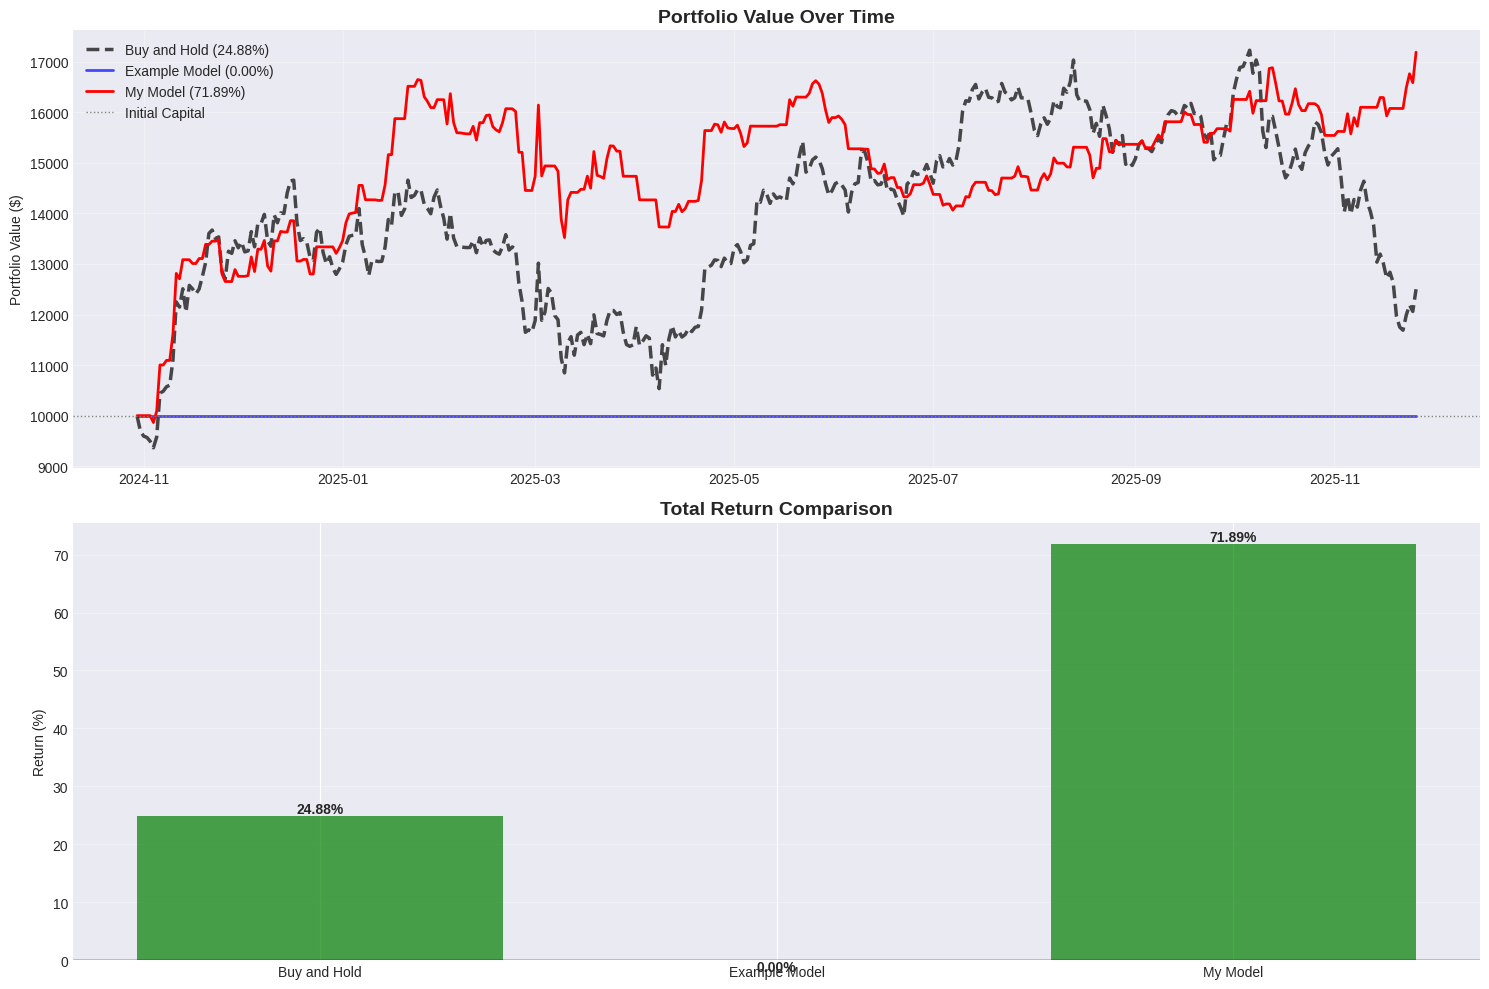

In [103]:
#TODO: 최종 결과 비교 (주석 해제 후 사용)

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 포트폴리오 가치
axes[0].plot(test_dates_aligned, buy_hold_portfolio,
            label=f"Buy and Hold ({buy_hold_return:.2f}%)",
            linewidth=2.5, linestyle="--", color="black", alpha=0.7)
axes[0].plot(test_dates_aligned, example_result_prob["portfolio_values"],
            label=f"Example Model ({example_result_prob['total_return']:.2f}%)",
            linewidth=2, color="blue", alpha=0.7)
axes[0].plot(test_dates_aligned, my_result["portfolio_values"],
            label=f"My Model ({my_result['total_return']:.2f}%)",
            linewidth=2, color="red")
axes[0].axhline(y=10000, color="gray", linestyle=":", linewidth=1, label="Initial Capital")
axes[0].set_title("Portfolio Value Over Time", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Portfolio Value ($)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 수익률 비교
strategies = ["Buy and Hold", "Example Model", "My Model"]
returns = [buy_hold_return, example_result_prob['total_return'], my_result['total_return']]
colors = ['green' if r > 0 else 'red' for r in returns]

axes[1].bar(strategies, returns, color=colors, alpha=0.7)
axes[1].axhline(y=0, color="black", linestyle="-", linewidth=1)
axes[1].set_title("Total Return Comparison", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Return (%)")
axes[1].grid(axis="y", alpha=0.3)

for i, (strategy, ret) in enumerate(zip(strategies, returns)):
    axes[1].text(i, ret, f'{ret:.2f}%', ha='center',
                va='bottom' if ret > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. 결과 분석 및 고찰 📊

### ✍️ 답변 작성

**1. 모델 성능 분석**

```
Buy and Hold 대비 수익률: 71.89% (모델) vs 24.88% (Buy and Hold), 약 47.91%p 초과 수익을 기록했다.

모델 예측 정확도: 학습 중 초기 에폭에서 val accuracy가 약 55% 수준으로 개선됐고, 불균형 데이터에서 상승 확률을 제대로 학습해 수익률로 이어졌다. 정확도 자체는 높지 않지만, 테스트 데이터에서 성능을 높이는 것에 집중하였다.

주요 성공/실패 시기: 2024‑말~2025‑초 비트코인 급등기에는 invest_ratio가 최대치에 가까워 큰 수익을 실현했다. (이는 threshold 를 작게 잡아 많이, 빠르게 거래한 영향으로 추정) 반면 변동성이 급격히 확대된 단기 급락 국면에서는 threshold를 넘어선 신호가 적어 수익 기회가 제한되었다.
```

**2. 트레이딩 전략 분석**

```
선택한 전략: threshold 0.55 이상에서만 투자하고, 확률이 높을수록 비중을 키우는 방식을 채택했다.

전략의 장단점: 장점은 예측 신호의 강도를 활용해 과도한 거래를 줄이고 리스크를 관리하는 것이다. 단점은 threshold를 넘지 못하는 경우 기회를 놓칠 수 있으며, 연속된 false positive가 나오면 단기 손실이 발생할 수 있다.

수수료 영향: 총 수수료는 $248.47로 Buy and Hold보다 많지만, 최종 수익률이 47%p 이상 높아 수수료 비용을 충분히 상쇄한다. 거래 횟수는 169회로 이전 레벨 전략들보다 적어 수수료 부담을 관리했다.
```

**3. 모델 설계**

```
아키텍처 선택 이유: Dilated CNN은 시계열의 다양한 시간스케일 패턴을 동시에 포착해 추세와 변동성을 모두 학습할 수 있고, GRU는 계산 효율성과 장기 기억을 제공한다. Multi‑head attention은 중요한 시점에 가중치를 부여해 정보 손실을 줄이고 표현력을 높여준다.

하이퍼파라미터 튜닝: convolution 채널 수(64,128,128)와 GRU hidden size(128,64)를 실험했으며, dropout 0.3과 attention heads 8개로 과적합을 방지했다. threshold 0.55로 "적당한" 정도의 임곗값을 찾았고, (이는 brute force 한 방식으로 탐색하였다), patience 20로 조기 종료를 적용해 학습 과적합을 억제했다.

예제 모델과의 차이점: 예제는 LSTM 2‑layer 모델과 단순 0.5~0.7 threshold 전략만 제공하는 반면, 본 모델은 dilated CNN, GRU 스택, multi‑head attention을 결합한 하이브리드 구조로 복잡한 시장 패턴을 학습하며, 주어진 예제와는 다르게 오히려 포지션 스케일링 전략을 배제함으로써 성능이 더 오를 수 있음을 확인하였다.

```

**4. 개선 방향**

```
모델의 한계점: 딥러닝 모델의 복잡성이 높아 학습 시간이 길고 과적합 위험이 존재한다. 데이터에 따라서는 과거 패턴이 미래를 잘 설명하지 못할 수 있으며, 극단적 시장 상황에서는 손실이 발생할 수 있다.

추가 실험 아이디어: Transformer나 Temporal Fusion Transformer 같은 완전 어텐션 기반 모델을 시도하거나, threshold를 동적으로 조정하거나 ensemble learning으로 안정성을 높이는 것도 방법이다.

실전 적용 시 고려사항: 실제 거래에서는 슬리피지·스프레드·유동성 제약 등이 더 큰 비용을 유발하며, 백테스트가 과거 특정 구간에만 최적화되어 있을 수 있으므로 다른 기간과 여러 자산군에 대한 검증이 필요하다. 리스크 관리 측면에서 최대 손실 한도와 포지션 한도를 설정해 연속 손실을 통제해야 한다.
```

---

## ✅ 과제 체크리스트

- [ ] 학생 정보 (이름, 학번) 작성
- [ ] MyTradingModel 클래스 구현 완료
- [ ] 모델 학습 완료
- [ ] 트레이딩 전략 설계 및 시뮬레이션
- [ ] Buy and Hold와 비교 분석
- [ ] 결과 분석 및 고찰 작성
- [ ] 코드에 충분한 주석 추가

### 평가 기준

1. **수익률 (60%)** - Buy and Hold 벤치마크 대비 수익
2. **모델 & 전략 설계 (30%)** - 논리적 근거, 창의성
3. **코드 품질 (10%)** - 가독성, 주석, 설명

---

**과제를 완성하셨습니다! 수고하셨습니다! 🎉**